In [1]:
import numpy as np
import scipy.io
import pandas as pd

from statsmodels.stats import multitest
from matplotlib import pyplot as plt
from scipy import stats
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from matplotlib import colors

dataset_location = '../corrs/'

In [2]:
pwd

'C:\\Users\\sarah\\Documents\\university\\NSC\\0_SS21\\TNM\\project\\scripts'

In [3]:
# test read in 
corr_file = scipy.io.loadmat(dataset_location + 'correlation_components_0487.mat')
corr = corr_file['corr_components']
corr.shape

(70876, 1)

In [4]:
corr_idx = np.unravel_index(np.arange(len(corr)), (377, 377))
corr_idx

(array([  0,   0,   0, ..., 187, 187, 187], dtype=int64),
 array([  0,   1,   2, ..., 374, 375, 376], dtype=int64))

In [5]:
print('min corr: ', np.min(corr),' | max corr: ', np.max(corr),' | mean corr; ', np.mean(corr))

min corr:  -0.7635846317736905  | max corr:  0.9377611026210455  | mean corr;  0.06329223946909276


<function matplotlib.pyplot.show(*args, **kw)>

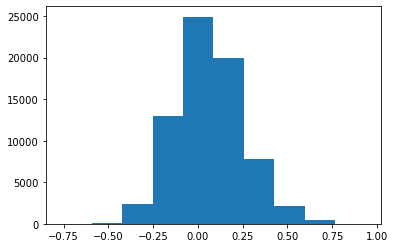

In [6]:
plt.hist(corr)
plt.show()

In [7]:
def flatt2mat(vec, dim):
    full_mat = np.zeros((dim, dim))
    triangle_indi = np.tril_indices(dim, -1) # we didn't save the main diagonal (would have been all ones)
    triangle_indi_order = np.argsort(triangle_indi[1], kind='stable') # annoyingly, these go row-by-row, but MATLAB outputted the data column-by-column
    triangle_indi = tuple(np.array(triangle_indi)[:,triangle_indi_order]) # sort the column indices to fix it

    full_mat[triangle_indi] = vec.flatten()
        
    return full_mat

In [8]:
corr_full = flatt2mat(corr, 377)
corr_full.shape

(377, 376)

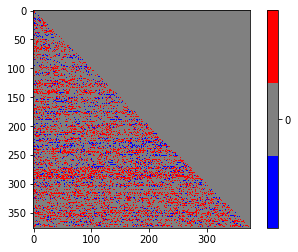

In [9]:
# make a color map of fixed colors
cmap = colors.ListedColormap(['blue', 'gray', 'red'])
bounds=[np.min(corr),-0.2,0.2,np.max(corr)]
norm = colors.BoundaryNorm(bounds, cmap.N)

# tell imshow about color map so that only set colors are used
img = plt.imshow(corr_full, interpolation='nearest', cmap=cmap, norm=norm)

# make a color bar
plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 5, 10])

In [10]:
# read in  correlation data 
corr_folder = Path(dataset_location).rglob('*.mat')
files = [x for x in corr_folder]

all_corrs = np.zeros((len(files), corr.shape[0] ))

for idx, name in enumerate(files):
    corr_file = scipy.io.loadmat(name)
    corr = corr_file['corr_components']
    if np.any(np.np.isnan(corr)):
        print(f'There are NaNs in subject {name}!')
    all_corrs[idx] = np.squeeze(corr)
                    
all_corrs.shape

(124, 70876)

In [11]:
participants = pd.read_table('../translational-neuromodelling-mdd/SRPBS_OPEN/participants.tsv')
labels = np.zeros((len(files)))
                  
# create labels 
for idx, name in enumerate(files):
    subID = 'sub-' + name.name[-8:-4]
    labels[idx] = int(participants[participants['participant_id'] == subID]['diag'])

labels = (labels / 2).astype(int)
labels

array([0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [12]:
# dinstinguish between mdd and hc 
controls = all_corrs[labels == 0]
patients = all_corrs[labels == 1]
controls.shape

(62, 70876)

In [13]:
# compute averages 
controls_avg = np.mean(controls, 0)
patients_avg = np.mean(patients, 0)

controls_avg_full = flatt2mat(controls_avg, 377)
patients_avg_full = flatt2mat(patients_avg, 377)

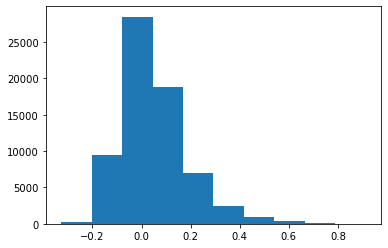

In [14]:
plt.hist(controls_avg)
plt.show()

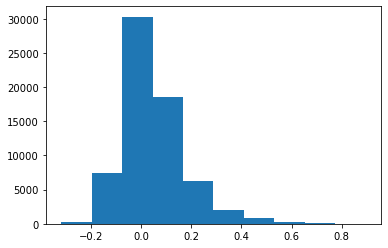

In [15]:
plt.hist(patients_avg)
plt.show()

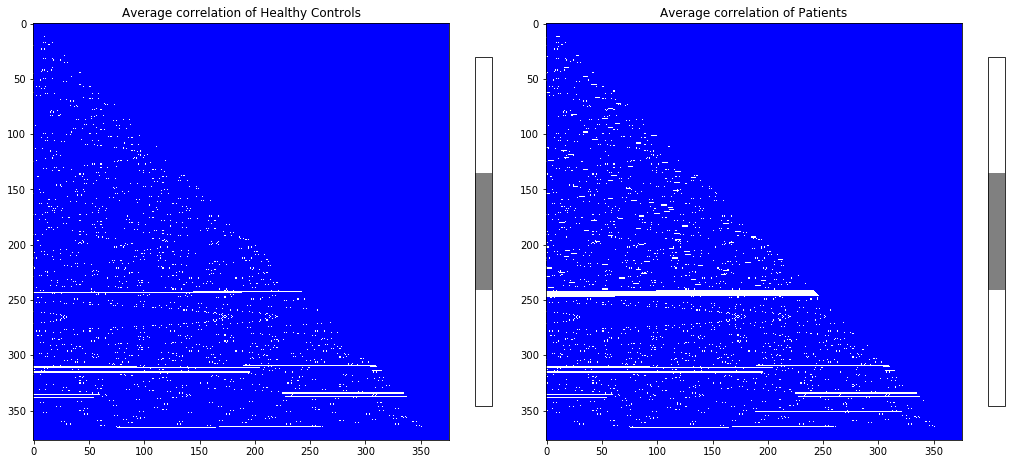

In [16]:
# make a color map of fixed colors
cmap = colors.ListedColormap(['blue', 'gray', 'red'])
bounds_c = [np.min(controls_avg),-0.15, 0.15, np.max(controls_avg)]
bounds_p = [np.min(patients_avg),-0.15, 0.15, np.max(patients_avg)]
norm_c = colors.BoundaryNorm(bounds_c, cmap.N)
norm_p = colors.BoundaryNorm(bounds_p, cmap.N)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))

ax[0].set_title('Average correlation of Healthy Controls')
img1 = ax[0].imshow(controls_avg_full, interpolation='nearest', cmap=cmap, norm=norm_c)
fig.colorbar(img1, ax=ax[0], cmap=cmap, norm=norm_c, boundaries=bounds_c, shrink=0.5)

ax[1].set_title('Average correlation of Patients')
img2 = ax[1].imshow(patients_avg_full, interpolation='nearest', cmap=cmap, norm=norm_p)
fig.colorbar(img2, ax=ax[1], cmap=cmap, norm=norm_p, boundaries=bounds_p, shrink=0.5)

plt.tight_layout()
plt.show() 

In [17]:
#do a t-test
statss, pvals = stats.ttest_ind(patients, controls)
sum(pvals <= 0.05)

5370

In [18]:
analysis = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False)
np.where(analysis[0])

(array([ 2625,  2761,  2957,  2993,  3129,  3325,  8070,  8386, 22147,
        25816, 33695, 47214, 47215, 58793, 70710], dtype=int64),)

In [19]:
all_corrs = np.nan_to_num(all_corrs)

In [20]:
clf = LogisticRegression(random_state=1).fit(all_corrs[:100, :], labels[:100])
clf.score(all_corrs[100:, :],labels[100:])

0.7083333333333334

In [21]:
clf_lasso = Lasso(0.1, fit_intercept=False, max_iter=1000).fit(all_corrs[:100, :], labels[:100])
clf_lasso.score(all_corrs[100:, :], labels[100:])

-0.02229021913244167